### This code generates text feature files using ocr.

In [ ]:
import os

import easyocr
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import dnn_superres

In [ ]:
def preprocess_image(image):
    # convert to grayscale
    image = image.convert("L")  
    
    # adjust the contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)  

    # remove noise
    image = image.filter(ImageFilter.MedianFilter(size=3)) 
    
    return image


def upscale_image(image, scale_factor=2):
    # upscale image
    width, height = image.size
    new_size = (width * scale_factor, height * scale_factor)
    return image.resize(new_size, Image.BICUBIC)



def upscale_with_super_resolution(image, scale=4, model_path="ESPCN_x4.pb"):
    # upscale image using OpenCV DNN Super Resolution
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Cannot find model: {model_path}")
    
    image = image.convert("RGB")
    image_np = np.array(image)

    # initialise the super resolution model
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel("espcn", scale) 

    result = sr.upsample(image_np)

    return Image.fromarray(result)

In [ ]:
def extract_and_visualize_text_with_preprocessing(image_path, rect_coords):
    reader = easyocr.Reader(['en']) 
    extracted_texts = []
    
    image = Image.open(image_path)
    model_path = "./ESPCN_x4.pb"

    for i, rect in enumerate(rect_coords):
        # crop the centre top region
        x1, y1, x2, y2 = rect
        cropped_image = image.crop((x1, y1, x2, y2))

        upscaled_image = upscale_with_super_resolution(cropped_image,model_path=model_path)

        # preprocess the image
        preprocessed_image = preprocess_image(upscaled_image)
        preprocessed_image_np = np.array(preprocessed_image)

        # extract text using OCR
        result = reader.readtext(preprocessed_image_np, detail=0, text_threshold=0.2, contrast_ths=0.1) 
        text = result[0] if result else "" 
        extracted_texts.append(text)

        # visualise
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cropped_image)
        plt.title(f"Original Region {i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title(f"Preprocessed Region {i+1}: {text}")
        plt.axis("off")

        plt.show()

    return extracted_texts

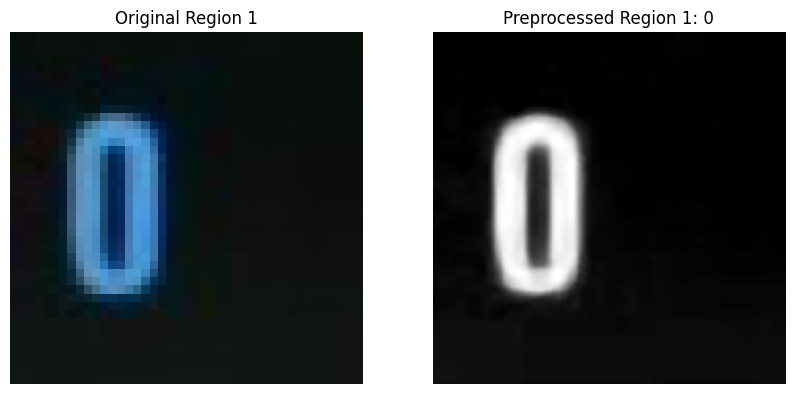

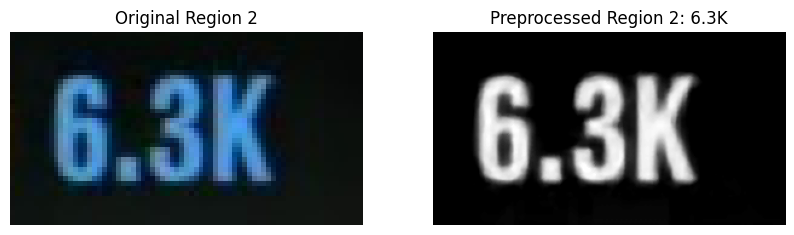

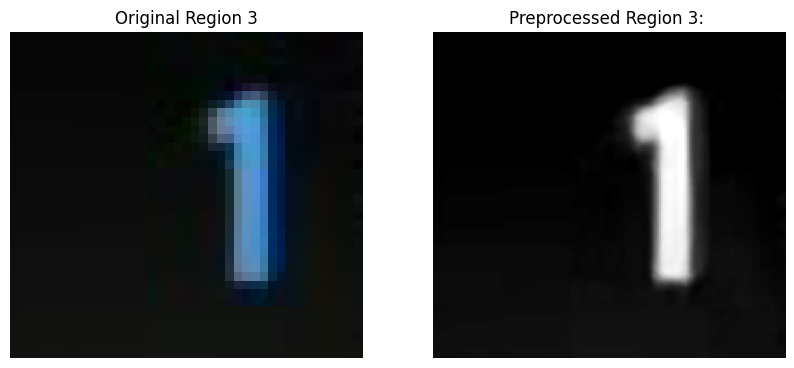

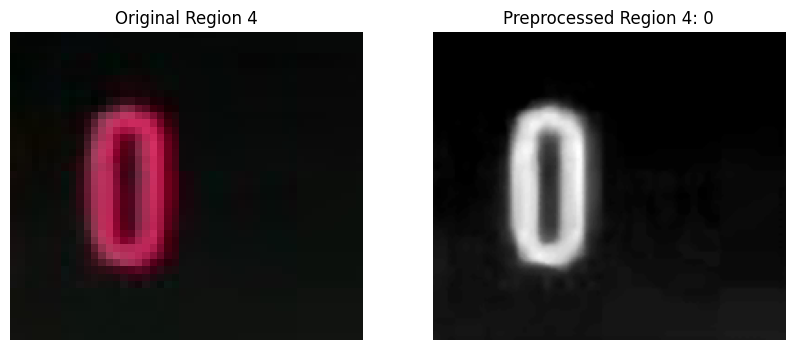

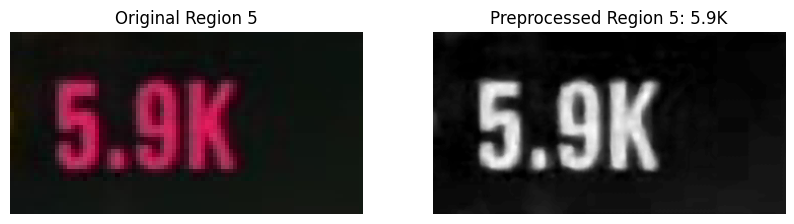

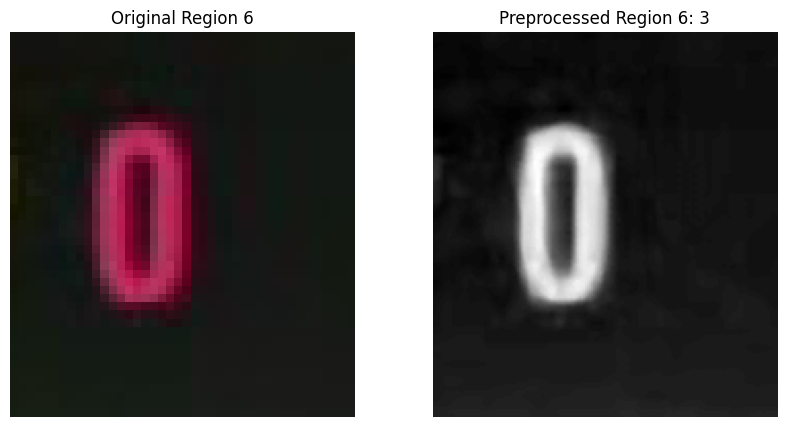

Extracted Texts:
Region 1: 0
Region 2: 6.3K
Region 3: 
Region 4: 0
Region 5: 5.9K
Region 6: 3


In [ ]:
rect_coords = [
    (725, 13, 768, 56), (799, 14, 872, 54), (912, 16, 953, 54),
    (969, 13, 1017, 55), (1066, 11, 1153, 56), (1194, 12, 1236, 59),
]

# example image
image_path = "./data/frames/106/frame_0008.jpg"

texts = extract_and_visualize_text_with_preprocessing(image_path, rect_coords)

print("Extracted Texts:")
for i, text in enumerate(texts):
    print(f"Region {i+1}: {text}")

In [ ]:
def extract_ocr_to_csv(image_dir, rect_coords, output_csv, model_path="ESPCN_x4.pb"):
    reader = easyocr.Reader(['en'])  
    ocr_results = []

    for root, _, files in os.walk(image_dir):
        for file in files:
            if not file.endswith('.jpg'):
                continue

            image_path = os.path.join(root, file)
            image = Image.open(image_path).convert("RGB")

            ocr_data = {"image": os.path.relpath(image_path, image_dir)} 

            for i, rect in enumerate(rect_coords):
                x1, y1, x2, y2 = rect
                cropped_image = image.crop((x1, y1, x2, y2))

                try:
                    upscaled_image = upscale_with_super_resolution(cropped_image, model_path=model_path)
                    preprocessed_image = preprocess_image(upscaled_image)
                    preprocessed_image_np = np.array(preprocessed_image)

                    result = reader.readtext(preprocessed_image_np, detail=0, text_threshold=0.2, contrast_ths=0.1)
                    # if fail, set as UNKNOWN
                    ocr_text = result[0] if result else "UNKNOWN" 
                except Exception as e:
                    # if error occurs, set as UNKNOWN
                    ocr_text = "UNKNOWN" 

                ocr_data[f"region_{i+1}"] = ocr_text

            ocr_results.append(ocr_data)

    ocr_df = pd.DataFrame(ocr_results)
    ocr_df.to_csv(output_csv, index=False)
    print(f"OCR data saved: {output_csv}")

image_dir = "./data/frames"
output_csv = "./ocr_results.csv"
rect_coords = [
    (725, 13, 768, 56), (799, 14, 872, 54), (912, 16, 953, 54),
    (969, 13, 1017, 55), (1066, 11, 1153, 56), (1194, 12, 1236, 59),
]

extract_ocr_to_csv(image_dir, rect_coords, output_csv, model_path="./ESPCN_x4.pb")

print(f"OCR data saved: ./ocr_results.csv")

OCR data saved: ./ocr_results.csv
